In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
data=pd.read_csv('full_data_test.csv')
columns2=["Long_Term_Fuel_Trim_Bank1","Intake_air_pressure","Accelerator_Pedal_value","Fuel_consumption","Torque_of_friction","Maximum_indicated_engine_torque","Engine_torque","Calculated_LOAD_value",
"Activation_of_Air_compressor","Engine_coolant_temperature","Transmission_oil_temperature","Wheel_velocity_front_left-hand","Wheel_velocity_front_right-hand","Wheel_velocity_rear_left-hand",
"Torque_converter_speed"]
from sklearn import svm
ano_det = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
ano_det.fit(data[columns2])


OneClassSVM(gamma=0.1, nu=0.1)

In [4]:
classes=['A','B','C','D','E','F','G','H','I','J']
drivers =[]
for c in classes:
    drivers.append(data[data['Class']==c])
dataa=[]
for c in range(len(drivers)):
    nt=0
    nv=0
    drivers[c]=drivers[c].reset_index(drop=True)
    idxs=drivers[c][drivers[c]['Time(s)']==1].index.values
    for i in range(len(idxs)):
      if i <(len(idxs)-1):
        nt=nt+1
        dataa.append(drivers[c][idxs[i]:idxs[i+1]])
      if i==(len(idxs)-1):
        nv=nv+1
        dataa.append(drivers[c][idxs[i]:])
    print("Driver : "+str(c)+" number of trips :"+str(len(idxs))+ "  For Train : "+str(nt)+"  For valid :"+str(nv))
    
drivers=[]
ss=0
for i in range(len(dataa)):
    #print(n)
    n=int(len(dataa[i])/60)
    #print(" Drive "+str(i)+" contains "+str(n)+" subdriversets")
    dd=0
    for j in range(n):
        #print(j)
        temp=dataa[i][dd:dd+60]
        temp=temp.reset_index(drop=True)
        drivers.append(temp)
        ss=ss+1
        dd=dd+60
print("total is "+str(ss))
samples = list()
labels=list()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[columns2].values)
for c in drivers:
    labels.append(c['Class'][0])
    del c['Class']
    del c['Time(s)']
    samples.append(scaler.transform(c[columns2].values))
data = np.array(samples)
print(data.shape)



Driver : 0 number of trips :4  For Train : 3  For valid :1
Driver : 1 number of trips :6  For Train : 5  For valid :1
Driver : 2 number of trips :4  For Train : 3  For valid :1
Driver : 3 number of trips :6  For Train : 5  For valid :1
Driver : 4 number of trips :4  For Train : 3  For valid :1
Driver : 5 number of trips :4  For Train : 3  For valid :1
Driver : 6 number of trips :4  For Train : 3  For valid :1
Driver : 7 number of trips :4  For Train : 3  For valid :1
Driver : 8 number of trips :4  For Train : 3  For valid :1
Driver : 9 number of trips :4  For Train : 3  For valid :1
total is 1551
(1551, 60, 15)


In [5]:
data[0].shape

(60, 15)

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels=le.transform(labels) 

from keras import optimizers

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=31)
X_test, X_predict, y_test, y_predict =train_test_split(X_test, y_test, test_size=0.1, random_state=31)

In [9]:
X_train.shape


(1085, 60, 15)

In [10]:
X_test.shape

(419, 60, 15)

In [11]:
X_predict.shape

(47, 60, 15)

In [12]:
data.shape[1]

60

In [13]:
data.shape[2]

15

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import *


from keras.models import Model
from keras.layers import Input, PReLU, Dense, LSTM, multiply, concatenate, Activation
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers

ip = Input(shape=(data.shape[1], data.shape[2]))
x = Permute((2, 1))(ip)
x=LSTM(10)(x)
x = Dropout(0.8)(x)
y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(ip)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
y = BatchNormalization()(y)
y = Activation('relu')(y)
y = GlobalAveragePooling1D()(y)
x = concatenate([x, y])
out = Dense(10, activation='sigmoid')(y)
model = Model(ip, out)



In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 15)]          0         
                                                                 
 conv1d (Conv1D)             (None, 60, 128)           15488     
                                                                 
 batch_normalization (BatchN  (None, 60, 128)          512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 60, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 256)           164096    
                                                                 
 batch_normalization_1 (Batc  (None, 60, 256)          1024      
 hNormalization)                                             

In [17]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=128, verbose=2)

Epoch 1/10
9/9 - 5s - loss: 0.3623 - accuracy: 0.8765 - val_loss: 0.6827 - val_accuracy: 0.7422 - 5s/epoch - 535ms/step
Epoch 2/10
9/9 - 2s - loss: 0.3159 - accuracy: 0.9069 - val_loss: 0.7419 - val_accuracy: 0.7327 - 2s/epoch - 188ms/step
Epoch 3/10
9/9 - 2s - loss: 0.2841 - accuracy: 0.9115 - val_loss: 0.6252 - val_accuracy: 0.7685 - 2s/epoch - 182ms/step
Epoch 4/10
9/9 - 2s - loss: 0.2465 - accuracy: 0.9373 - val_loss: 0.6419 - val_accuracy: 0.7685 - 2s/epoch - 189ms/step
Epoch 5/10
9/9 - 2s - loss: 0.2310 - accuracy: 0.9355 - val_loss: 0.5527 - val_accuracy: 0.7804 - 2s/epoch - 189ms/step
Epoch 6/10
9/9 - 2s - loss: 0.2143 - accuracy: 0.9281 - val_loss: 0.5502 - val_accuracy: 0.8067 - 2s/epoch - 183ms/step
Epoch 7/10
9/9 - 2s - loss: 0.2102 - accuracy: 0.9419 - val_loss: 0.5254 - val_accuracy: 0.7971 - 2s/epoch - 184ms/step
Epoch 8/10
9/9 - 2s - loss: 0.1892 - accuracy: 0.9502 - val_loss: 0.4929 - val_accuracy: 0.7995 - 2s/epoch - 186ms/step
Epoch 9/10
9/9 - 2s - loss: 0.1680 - acc

In [18]:
model.save('Driver_Profiling.h5')

In [19]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 20ms/step - loss: 0.5447 - accuracy: 0.7757


[0.5447229146957397, 0.7756563425064087]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


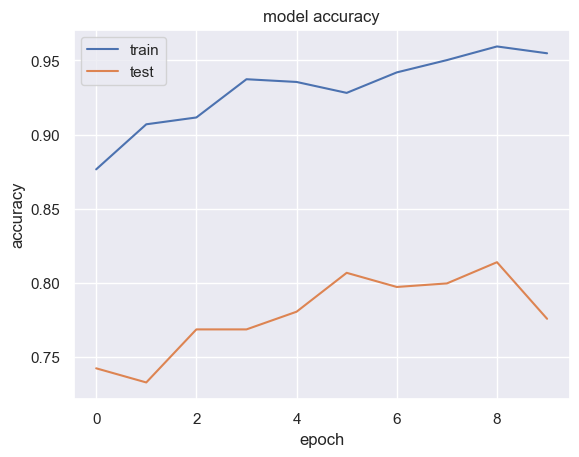

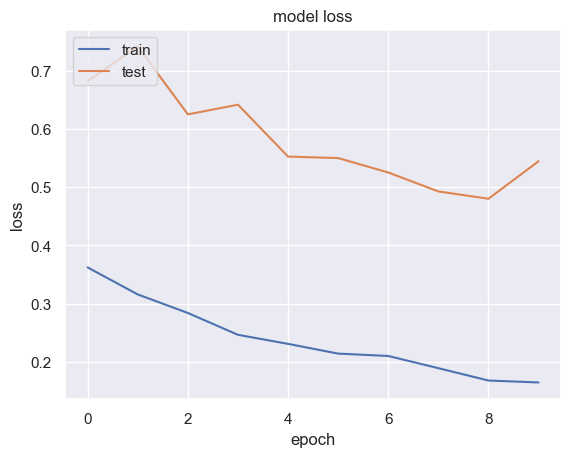

In [20]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
import sys
sys.path.insert(0, 'MLSTM-FCN/utils')
from layer_utils import AttentionLSTM



In [21]:
import random
rates=[0,0.01,0.1,0.3,0.5]
rows=[1,10]
sensors=[7]

results=pd.DataFrame(columns=["Rate","Rows","Sensors","Accuracy"])
for rate in rates:
  for row in rows:
    for sensor in sensors:
      X_test2=X_test.copy()
      total=X_test.shape[0]*X_test.shape[1]*X_test.shape[2]
      total=int(311*rate)
      n=sensor
      nrows=row
      for i in range(total):
        if(i%10000==0):
          print(i)
        fst=random.randint(0,X_test.shape[0]-1)
        snd=random.randint(0,X_test.shape[1]-nrows)
        trh2=random.sample(range(0, X_test.shape[2]), n)
        for j in range(n):
          for jj in range(nrows):
            X_test2[fst][snd+jj][trh2[j]]=X_test2[fst][snd+jj][trh2[j]]+3000
      acc=round(model.evaluate(X_test2, y_test)[1]*100,2)
      results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)

        
print(results)

 1/14 [=>............................] - ETA: 0s - loss: 0.5676 - accuracy: 0.7812

C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 21ms/step - loss: 0.5447 - accuracy: 0.7757
0
 1/14 [=>............................] - ETA: 0s - loss: 0.5676 - accuracy: 0.7812

C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 20ms/step - loss: 8.4124 - accuracy: 0.7733
0
 1/14 [=>............................] - ETA: 0s - loss: 17.8762 - accuracy: 0.7500

C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 23ms/step - loss: 17.2848 - accuracy: 0.7733
0
 1/14 [=>............................] - ETA: 0s - loss: 49.9900 - accuracy: 0.7188

C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 20ms/step - loss: 47.8077 - accuracy: 0.7112
0
 1/14 [=>............................] - ETA: 0s - loss: 259.4438 - accuracy: 0.6875

C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 19ms/step - loss: 269.2149 - accuracy: 0.7232
0
 1/14 [=>............................] - ETA: 0s - loss: 197.2160 - accuracy: 0.5625

C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 20ms/step - loss: 130.4946 - accuracy: 0.6348
0


C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 18ms/step - loss: 802.4320 - accuracy: 0.6396
0
 4/14 [=======>......................] - ETA: 0s - loss: 232.1292 - accuracy: 0.5625

C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 21ms/step - loss: 205.0714 - accuracy: 0.5656
0
 1/14 [=>............................] - ETA: 0s - loss: 1020.1887 - accuracy: 0.5625

C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


14/14 [==============================] - 0s 20ms/step - loss: 1252.8104 - accuracy: 0.5513
    Rate Rows Sensors  Accuracy
0     0%    1       7     77.57
1     0%   10       7     77.57
2   1.0%    1       7     77.33
3   1.0%   10       7     77.33
4  10.0%    1       7     71.12
5  10.0%   10       7     72.32
6  30.0%    1       7     63.48
7  30.0%   10       7     63.96
8  50.0%    1       7     56.56
9  50.0%   10       7     55.13


C:\Users\SIDDHI MANGALAM\AppData\Local\Temp\ipykernel_13840\1950611545.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Rate': str(rate*100)+"%",'Rows': str(row)+"",'Sensors': str(sensor)+"",'Accuracy': acc}, ignore_index=True)


In [22]:
model =keras.models.load_model('Driver_Profiling.h5')

In [36]:
Live_Data= np.expand_dims(X_predict[10],axis=0)

In [24]:
X_predict[1].shape

(60, 15)

In [25]:
Live_Data

array([[[-1.20132885,  1.36150927, -0.48442561, -0.27860847,
          1.19332582,  0.27347669,  0.45313868,  1.08571287,
          0.80689285,  0.81418371,  1.89457971, -0.73189734,
         -0.75492777, -0.7275848 , -0.84390211],
        [-1.18640411,  1.477355  , -0.48442561, -0.31435071,
          1.31769264,  0.36620547,  0.44113292,  1.26890673,
          0.89293393,  0.96732974,  2.05498343, -1.07632913,
         -1.09803863, -1.0796303 , -1.2712003 ],
        [-1.77905474,  1.49179052, -0.48442561, -0.42188585,
          1.42575507,  0.47835202,  0.36202355,  1.20058219,
          0.96769508,  1.17527059,  2.19435833, -1.19303361,
         -1.18801937, -1.19140738, -1.89521198],
        [-1.77905474,  1.51771017, -0.48442561, -0.51206285,
          1.4719972 ,  0.39291287,  0.47331317,  1.26563619,
          0.99968692,  1.23289948,  2.25399972, -1.21012392,
         -1.18801937, -1.20859724, -1.91363998],
        [-1.77905474,  1.56579994, -0.48442561, -0.51191152,
          1

In [26]:
Live_Data.shape

(1, 60, 15)

In [37]:
pred = model.predict(Live_Data)

1/1 [==============================] - 0s 38ms/step


In [28]:
pred

array([[0.99960303, 0.12175708, 0.02143989, 0.02960223, 0.21228309,
        0.16210207, 0.62265265, 0.20330425, 0.1664377 , 0.06755012]],
      dtype=float32)

In [38]:
np.argmax(pred)

5

In [39]:
y_predict[10]

5

In [31]:
y_predict

array([1, 0, 3, 4, 6, 4, 3, 1, 9, 5, 5, 8, 9, 4, 1, 3, 0, 1, 6, 7, 1, 3,
       9, 8, 2, 6, 8, 3, 5, 1, 3, 1, 7, 3, 5, 7, 5, 1, 1, 6, 9, 0, 2, 0,
       1, 3, 6], dtype=int64)

In [32]:
y_predict.shape

(47,)